In [1]:
import pandas as pd
import glob
import codecs
from pandas import Series, DataFrame

from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import Adam,RMSprop
from keras.utils import np_utils
from keras import optimizers,regularizers
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#圧力_温度_配管ID.csvの読み込み
data1 = pd.read_csv("drive/My Drive/mdb/test/C61/圧力_温度_配管ID.csv", encoding='shift_jis')
data1

,From,To,材質,配管 ID,呼び径 (mm),ｹｰｽ 1 圧力 (N/mm2),ｹｰｽ 1 温度 (deg C),ｹｰｽ 1 自動_1,ｹｰｽ 1 線膨張量 (mm/m),ｹｰｽ 1 自動_2,ｹｰｽ 1 運転時弾性係数 (E6 N/mm2),ｹｰｽ 1 自動_3,ｹｰｽ 1 運転時許容応力 (N/mm2)
0,A00,A01,STPA12-S,E300S120,300.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
1,A01,A02 N,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
2,A02 N,A02 F,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
3,A02 F,A03 N,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
4,A03 N,A03 F,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B17,B18 N,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
66,B18 N,B18 F,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
67,B18 F,B19,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51
68,B19,B20,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51


In [4]:
#配管特性.csvの読み込み
data2 = pd.read_csv('drive/My Drive/mdb/test/C61/配管特性.csv',encoding='shift_jis')
data2

,配管ID,ﾀｸﾞ ﾅﾝﾊﾞｰ,呼び径 (mm),実外径 (mm),ｽｹｼﾞｭｰﾙ,肉厚 (mm),腐れ代 (mm),製作公差 (mm),保温厚さ (mm),保温材質,保温材密度 (kg/m3),外装板厚 (mm),外装板材質,外装板密度 (kg/m3),ﾗｲﾆﾝｸﾞ厚さ (mm),ﾗｲﾆﾝｸﾞ密度 (kg/m3),ﾗｲﾝ ｸﾗｽ,流体比重,配管材質,最低温度の警告,溶接E係数,溶接W係数 自動,溶接W係数,応力振幅 低減係数,常温時許容応力 (N/mm2),最小降伏点(Sy) (N/mm2),引張強さ(Su) (N/mm2),縦弾性係数 (E6 N/mm2),周方向弾性係数 (E6 N/mm2),せん断弾性係数 (E6 N/mm2),密度 (kg/m3),ﾎﾟｱｿﾝ比
0,P250S120,,250,267.4,120,21.4,0.0,2.67,140.0,Other,201.28,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
1,E300S120,,300,318.5,120,25.4,0.0,3.17,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
2,P350S120,,350,355.6,120,27.8,0.0,3.47,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
3,P25S40,,25,34.0,40,3.4,0.0,0.42,90.0,Other,201.22,0.0,,,0.0,,EH21,0.0,STPT480-S,0.0,1.0,,,1.0,121.0,275.0,480.0,0.20,0.20,0.07,7850.0,0.3
4,E25S40,,25,34.0,40,3.4,0.0,0.42,90.0,Other,201.22,0.0,,,0.0,,EH21,0.0,SF490A,0.0,1.0,,,1.0,121.0,245.0,490.0,0.20,0.20,0.07,7850.0,0.3


In [5]:
#圧力_温度_配管ID.csvのデータの配管IDに合わせて配管特性.csvのデータを結合
data1_frame = DataFrame(data1)
data2_frame = DataFrame(data2)
data12 = pd.merge(data1_frame,data2_frame,how='left',left_on='配管 ID',right_on = '配管ID')
data12

,From,To,材質,配管 ID,呼び径 (mm)_x,ｹｰｽ 1 圧力 (N/mm2),ｹｰｽ 1 温度 (deg C),ｹｰｽ 1 自動_1,ｹｰｽ 1 線膨張量 (mm/m),ｹｰｽ 1 自動_2,ｹｰｽ 1 運転時弾性係数 (E6 N/mm2),ｹｰｽ 1 自動_3,ｹｰｽ 1 運転時許容応力 (N/mm2),配管ID,ﾀｸﾞ ﾅﾝﾊﾞｰ,呼び径 (mm)_y,実外径 (mm),ｽｹｼﾞｭｰﾙ,肉厚 (mm),腐れ代 (mm),製作公差 (mm),保温厚さ (mm),保温材質,保温材密度 (kg/m3),外装板厚 (mm),外装板材質,外装板密度 (kg/m3),ﾗｲﾆﾝｸﾞ厚さ (mm),ﾗｲﾆﾝｸﾞ密度 (kg/m3),ﾗｲﾝ ｸﾗｽ,流体比重,配管材質,最低温度の警告,溶接E係数,溶接W係数 自動,溶接W係数,応力振幅 低減係数,常温時許容応力 (N/mm2),最小降伏点(Sy) (N/mm2),引張強さ(Su) (N/mm2),縦弾性係数 (E6 N/mm2),周方向弾性係数 (E6 N/mm2),せん断弾性係数 (E6 N/mm2),密度 (kg/m3),ﾎﾟｱｿﾝ比
0,A00,A01,STPA12-S,E300S120,300.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,E300S120,,300,318.5,120,25.4,0.0,3.17,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
1,A01,A02 N,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P350S120,,350,355.6,120,27.8,0.0,3.47,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
2,A02 N,A02 F,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P350S120,,350,355.6,120,27.8,0.0,3.47,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
3,A02 F,A03 N,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P350S120,,350,355.6,120,27.8,0.0,3.47,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
4,A03 N,A03 F,STPA12-S,P350S120,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P350S120,,350,355.6,120,27.8,0.0,3.47,150.0,Other,201.23,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,B17,B18 N,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P250S120,,250,267.4,120,21.4,0.0,2.67,140.0,Other,201.28,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
66,B18 N,B18 F,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P250S120,,250,267.4,120,21.4,0.0,2.67,140.0,Other,201.28,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
67,B18 F,B19,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P250S120,,250,267.4,120,21.4,0.0,2.67,140.0,Other,201.28,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3
68,B19,B20,STPA12-S,P250S120,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,P250S120,,250,267.4,120,21.4,0.0,2.67,140.0,Other,201.28,0.0,,,0.0,,EH21,0.0,STPA12-S,0.0,1.0,,,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3


In [6]:
#'To'データの削除
data12 = data12.drop("To",axis=1)
for col_name in data12.columns:
    print(col_name,data12[col_name].dtype)

#結合後のデータ種類
data12
#'配管ID'などの文字データのダミー化
data12_dummy = pd.get_dummies(data12[data12.columns[data12.columns != 'From']])
data12_dummy['From'] = data12['From']

data12_dummy
#Support.csvの読み込み
data_out = pd.read_csv("drive/My Drive/mdb/test/C61/Support.csv",encoding='shift_jis')
data_out
#使用したい "Point","Type"データのみにする
for col_name in data_out.columns:
    if col_name != "Point" and col_name != "Type" :
        data_out = data_out.drop(col_name,axis=1)
data_out
#重複しているデータの削除
data_out = data_out.drop_duplicates()
data_out
#入力データと出力データを'Point'データで結合
data_press_type = pd.merge(data12_dummy,data_out,how = "outer",left_on = 'From',right_on='Point')
data_press_type
#'Support.csv'の'type'データの確認
data_series = Series(data_press_type['Type'])
pd.Series.value_counts(data_series)

From object
材質 object
配管 ID object
呼び径 (mm)_x float64
ｹｰｽ 1 圧力 (N/mm2) float64
ｹｰｽ 1 温度 (deg C) float64
ｹｰｽ 1 自動_1 float64
ｹｰｽ 1 線膨張量 (mm/m) float64
ｹｰｽ 1 自動_2 float64
ｹｰｽ 1 運転時弾性係数 (E6 N/mm2) float64
ｹｰｽ 1 自動_3 float64
ｹｰｽ 1 運転時許容応力 (N/mm2) float64
配管ID object
ﾀｸﾞ ﾅﾝﾊﾞｰ object
呼び径 (mm)_y int64
実外径 (mm) float64
ｽｹｼﾞｭｰﾙ int64
肉厚 (mm) float64
腐れ代 (mm) float64
製作公差 (mm) float64
保温厚さ (mm) float64
保温材質 object
保温材密度 (kg/m3) float64
外装板厚 (mm) float64
外装板材質 object
外装板密度 (kg/m3) object
ﾗｲﾆﾝｸﾞ厚さ (mm) float64
ﾗｲﾆﾝｸﾞ密度 (kg/m3) object
ﾗｲﾝ ｸﾗｽ object
流体比重 float64
配管材質 object
最低温度の警告 float64
溶接E係数 float64
溶接W係数 自動 object
溶接W係数 object
応力振幅 低減係数 float64
常温時許容応力 (N/mm2) float64
最小降伏点(Sy) (N/mm2) float64
引張強さ(Su) (N/mm2) float64
縦弾性係数 (E6 N/mm2) float64
周方向弾性係数 (E6 N/mm2) float64
せん断弾性係数 (E6 N/mm2) float64
密度 (kg/m3) float64
ﾎﾟｱｿﾝ比 float64


V - Stop    4
Guide       3
Spr. Hgr    2
Inclined    1
Name: Type, dtype: int64

In [7]:
#文字データなのでダミー化
data_press_type.at[data_press_type['Type'] == "Guide",'Type'] = 1
data_press_type.at[data_press_type['Type'] == "V - Stop",'Type'] = 2
data_press_type.at[data_press_type['Type'] == "Spr. Hgr",'Type'] = 3
data_press_type.at[data_press_type['Type'] == "Inclined",'Type'] = 4
data_test_press = data_press_type.fillna(0)
data_series = Series(data_test_press['Type'])
print(pd.Series.value_counts(data_series))
data_test_press = data_test_press[data_test_press["呼び径 (mm)_x"] != 0]
data_test_press

0    60
2     4
1     3
3     2
4     1
Name: Type, dtype: int64


,呼び径 (mm)_x,ｹｰｽ 1 圧力 (N/mm2),ｹｰｽ 1 温度 (deg C),ｹｰｽ 1 自動_1,ｹｰｽ 1 線膨張量 (mm/m),ｹｰｽ 1 自動_2,ｹｰｽ 1 運転時弾性係数 (E6 N/mm2),ｹｰｽ 1 自動_3,ｹｰｽ 1 運転時許容応力 (N/mm2),呼び径 (mm)_y,実外径 (mm),ｽｹｼﾞｭｰﾙ,肉厚 (mm),腐れ代 (mm),製作公差 (mm),保温厚さ (mm),保温材密度 (kg/m3),外装板厚 (mm),ﾗｲﾆﾝｸﾞ厚さ (mm),流体比重,最低温度の警告,溶接E係数,応力振幅 低減係数,常温時許容応力 (N/mm2),最小降伏点(Sy) (N/mm2),引張強さ(Su) (N/mm2),縦弾性係数 (E6 N/mm2),周方向弾性係数 (E6 N/mm2),せん断弾性係数 (E6 N/mm2),密度 (kg/m3),ﾎﾟｱｿﾝ比,材質_STPA12-S,配管 ID_E300S120,配管 ID_P250S120,配管 ID_P350S120,配管ID_E300S120,配管ID_P250S120,配管ID_P350S120,ﾀｸﾞ ﾅﾝﾊﾞｰ_,保温材質_Other,外装板材質_,外装板密度 (kg/m3)_,ﾗｲﾆﾝｸﾞ密度 (kg/m3)_,ﾗｲﾝ ｸﾗｽ_EH21,配管材質_STPA12-S,溶接W係数 自動_,溶接W係数_,From,Point,Type
0,300.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,300,318.5,120,25.4,0.0,3.17,150.0,201.23,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,A00,0,0
1,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,350,355.6,120,27.8,0.0,3.47,150.0,201.23,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,A01,0,0
2,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,350,355.6,120,27.8,0.0,3.47,150.0,201.23,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,A02 N,0,0
3,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,350,355.6,120,27.8,0.0,3.47,150.0,201.23,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,A02 F,0,0
4,350.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,350,355.6,120,27.8,0.0,3.47,150.0,201.23,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,A03 N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,250,267.4,120,21.4,0.0,2.67,140.0,201.28,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,B17,0,0
66,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,250,267.4,120,21.4,0.0,2.67,140.0,201.28,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,B18 N,0,0
67,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,250,267.4,120,21.4,0.0,2.67,140.0,201.28,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,B18 F,0,0
68,250.0,10.6,487.0,1.0,6.58,1.0,0.15,1.0,83.51,250,267.4,120,21.4,0.0,2.67,140.0,201.28,0.0,0.0,0.0,0.0,1.0,1.0,95.0,205.0,380.0,0.19,0.19,0.07,7850.0,0.3,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,B19,0,0


In [23]:
np.random.seed(0) # 乱数を固定値で初期化し再現性を持たせる
X = data_test_press.drop(['From','Point','Type'],axis=1)
T = data_test_press['Type']
(n_samples,n_features)=X.shape
n_classes=len(np.unique(T))

print(n_features)

T = np_utils.to_categorical(T) # 数値を、位置に変換 [0,1,2] ==> [ [1,0,0],[0,1,0],[0,0,1] ]
train_x, test_x, train_t, test_t = train_test_split(X, T, train_size=0.7, test_size=0.3)


47


In [24]:
#モデル作成

model = Sequential()
model.add(Dense(100,activation="relu",input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=n_classes,activation="softmax"))

model.summary()
model.compile(loss='mean_squared_error', optimizer=Adam(),metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               4800      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               5100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                

In [25]:
#トレーニング

history=model.fit(X,T,epochs=600,batch_size=100,verbose=1,validation_data=(test_x,test_t))
result=model.predict_classes(X,verbose=0)

Train on 70 samples, validate on 21 samples
Epoch 1/600
70/70 [==============================] - 1s 8ms/step - loss: 0.1457 - acc: 0.6286 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 2/600
70/70 [==============================] - 0s 132us/step - loss: 0.1714 - acc: 0.5714 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 3/600
70/70 [==============================] - 0s 120us/step - loss: 0.1777 - acc: 0.5571 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 4/600
70/70 [==============================] - 0s 93us/step - loss: 0.1486 - acc: 0.6286 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 5/600
70/70 [==============================] - 0s 94us/step - loss: 0.1533 - acc: 0.6143 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 6/600
70/70 [==============================] - 0s 95us/step - loss: 0.1429 - acc: 0.6429 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 7/600
70/70 [==============================] - 0s 91us/step - loss: 0.1099 - acc: 0.7286 - val_loss: 0.0762 - val_acc: 0.8095
Epoch 8/600
70/70 [============

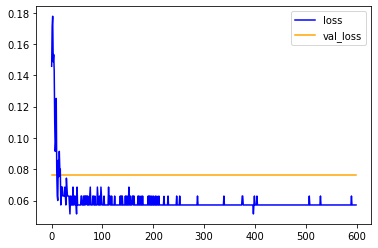

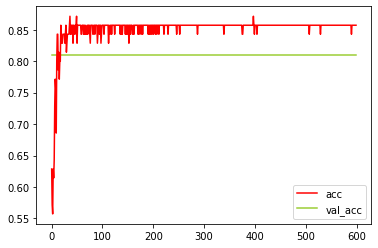

In [28]:
#以下で損失関数のグラフを描画
val_loss,=plt.plot(history.history["val_loss"],c="orange")
loss,=plt.plot(history.history["loss"],c="blue")
plt.legend([loss,val_loss],["loss","val_loss"])
plt.show()
#accuracyをグラフ化
val_acc,=plt.plot(history.history["val_acc"],c="yellowgreen")
acc,=plt.plot(history.history["acc"],c="red")
plt.legend([acc,val_acc],["acc","val_acc"])
plt.show()

In [0]:
#データの分類
from sklearn.model_selection import train_test_split
#決定木
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#説明変数と目的変数
X = data_test_press.drop(['From','Point','Type'],axis=1)
Y = data_test_press['Type']

#データを分ける
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 100)

#決定木インスタンス（エントロピー、深さ5）
tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state = 100)

#fitting
tree_model.fit(X_train,Y_train)

#結果
print("train:",tree_model.__class__.__name__,tree_model.score(X_train,Y_train))
print("test:",tree_model.__class__.__name__ , tree_model.score(X_test,Y_test))

train: DecisionTreeClassifier 0.8571428571428571
test: DecisionTreeClassifier 0.8571428571428571
